## Test new concepts 

#### Initialize/ Modify these

In [44]:
# Initialize these:
import pandas as pd

# path to the git repo's downloads folder
path = "E:/GitRepo/Color-Concept-Associaitons-using-Google-Images/downloads" 

# Folder inside downloads where the new concepts test images are.
typeImg = "newTestConcepts" 

# Image resized to sz x sz
sz = 100 

# insert new concepts here.
allConcepts = ["Roses","Trees"] 

In [ ]:
# save these concepts to a csv -- to avoid restating the allConcepts again
df = pd.DataFrame(allConcepts)
## save to csv file
filepath = 'testConcepts.csv'
df.to_csv(filepath, index=False, header = None)

## # Weights from Exp 1C
weights = [0.13858045, 0.13921446, 0.12137094, 0.30032727]

#### Initialize/ Modify the cell below if using different set of colors. Default colors: UW-58

In [ ]:
# Comment if using other colors than the UW-58 -- curate new data similar to this cell


numColors = 58 # number of new colors here.
colNames = ["col_"+str(i) for i in range(numColors)] 

# # Read data
# # Get the color ratings data -From file data_newColors.csv (Optional)
## IF there is no data, simply comment it out.
data = pd.read_csv("data.csv",names = colNames)   # < This uses UW-58 by default. >

# Get the LAB coordinates of colors from file Lab.csv (Required)
colorData = pd.read_csv("Lab.csv",header=None)
colorDataRGB = pd.read_csv("RGB.csv",header=None)

# Categorical information about the colors (Required)
category = pd.read_csv("Category.csv",header=None)

#### Uncomment below if the colors to be used are BCP-37 as in Exp3

In [ ]:
# OPTIONAL (reference the color data here)
# Uncomment to select BCP-37 colors as target colors

# numColors = 37 # number of new colors here.
# colNames = ["col_"+str(i) for i in range(numColors)] 

# # # Read data
# # # Get the color ratings data -From file data_newColors.csv (Optional)
# IF there is no data, simply comment it out.
# data = pd.read_csv("TestScripts/data_test.csv",names = colNames)

# # Get the LAB coordinates of colors from file Lab.csv (Required)
# colorData = pd.read_csv("TestScripts/Lab_test.csv",header=None)
# colorDataRGB = pd.read_csv("TestScripts/RGB_test.csv",header=None)

# # Categorical information about the colors (Required)
# category = pd.read_csv("TestScripts/Category_test.csv",header=None)

## Download the images (Optional)

In [ ]:
pip install google_images_download 

In [46]:
# Add the concepts as keywords

from google_images_download import google_images_download
response = google_images_download.googleimagesdownload()
arguments = {"keywords_from_file":"testConcepts.csv","limit":50, "output_directory":"downloads/newTestConcepts", "format":"jpg"}   #creating list of arguments
paths = response.download(arguments)

# type = (face, photo, clip-art, line-drawing, animated)
# format = jpg, gif, png, bmp, svg, webp, ico, raw


Item no.: 1 --> Item name = Ship
Evaluating...
Starting Download...
Completed Image ====> 1. boatnew.jpg
Completed Image ====> 2. 5cbf50dfd1a2f8074406a8b2-750-562.jpg
Completed Image ====> 3. shipslanding_splendor_mobile.jpg
Completed Image ====> 4. amerigo-vespucci.jpg
Completed Image ====> 5. firenze.jpg

Errors: 0



In [47]:
# # Include imports
import glob
from skimage.transform import resize
from skimage.io import imread, imsave, imshow
import os

import numpy as np
import skimage.color as skcolor
import matplotlib.pyplot as plt

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import time

## Uses the first 50 images from the test concepts

In [48]:
# Count total number of images

count = 0
for i in allConcepts:
    print(path + "/" +typeImg +"/" +i+"/*.*")
    trainFiles = glob.glob( path + "/" +typeImg +"/" +i+"/*.*" )
    count = count + len(trainFiles[:50])
    #print(count)
print("Category: ",typeImg)
print("Total images : ",count)

E:/GitRepo/Color-Concept-Associaitons-using-Google-Images/downloads/newTestConcepts/Ship/*.*
Category:  newTestConcepts
Total images :  50


## Extracting features from test Images

#### Features to be extracted are from Exp 1C

In [49]:
import matlab.engine
def getCategoriesMatrix(imageFileName,sz):
    ## Get total pixel counts of all 11 categories for this imageFile
    eng = matlab.engine.start_matlab()
    imageCat = np.array(eng.getCategories(imageFileName,sz))
    eng.quit()
     # imageCat : sz x sz matrix where each pixel has its category
    return imageCat

def getSegmentedImage(imageFileName,sz): # Returns segmented pixels in LAB and its corresponding color category.
    eng = matlab.engine.start_matlab()
    segImg, segImgCat = eng.activeContourSegmentation(imageFileName,sz, nargout=2)
    eng.quit()
    segImg = np.array(segImg)/255;
    segImg = skcolor.rgb2lab(segImg)
    segImgCat = np.array(segImgCat)
    return segImg, segImgCat


In [50]:
numFt = 3
X = np.zeros((count*numColors,numFt+1) )  # +1 for label #Number of features [] # Feature Vector -- 58N rows
init = time.time()
rowNum = -1
strtInd = []  # To keep track of the starting indices of concepts in the feature matrix
cvInd = 1 
counter = 0
sz = 100    # Size of image: 100 by 100

Rc = [1,10,20,30,40]   # Radii thresholds - not required
Li = [40]              #[1, 10, 20, 30, 40]
R = [40]               #[1, 10, 20, 30, 40]     # same as L
hueAngle = [40]        #[5, 10, 20, 30, 40] # Hue Angle
##
for conceptNum,concept in enumerate(allConcepts):
    #conceptNum = 5
    t0 = time.time()
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>\n",conceptNum+1,": Concept : ",concept)
    ct = 0    # Keeps track of images inside a category
    strtInd.append(counter)
    trainFiles = glob.glob( path + "/" +typeImg +"/" +concept+"/*.*" )
    print("\tTotal number of images for ",concept," : ",len(trainFiles))
    t = []
    for m, nameFile in enumerate(trainFiles[:50]):
        t1 = time.time()
        #print("\nReading file ......")
        ct = ct + 1
        
        image = imread( nameFile )
        imageResized = resize( image, (sz,sz),anti_aliasing=True,mode='reflect')
        img = imageResized
        # Convert the pixels in  image to LAB space
        imgLAB = skcolor.rgb2lab(img)
        segmentedImg,segmentedImgCat = getSegmentedImage(nameFile,sz)
        imageWithCategories = getCategoriesMatrix(nameFile,sz)
        
        i1 = imgLAB[27:72,27:72,:] 
        i6 = np.copy(segmentedImg)
        
        ii1 = imageWithCategories[27:72,27:72].flatten()
        
        categoryImg1 = [sum(1 for p in ii1 if p-1 == k)/ii1.size for k in range(11)]
      
        for color in range(numColors):
            rowNum+=1
            counter += 1
            colCt = 0
            colorLAB = np.array(colorData.loc[color])   #get LAB values for specific color

            # Just need 2 features from Sectors
            for i in [0,5]:
                if i == 0:
                    L = i1[:,:,0]
                    a = i1[:,:,1]
                    b = i1[:,:,2]
                elif i == 1:
                    L = i2[:,:,0]
                    a = i2[:,:,1]
                    b = i2[:,:,2]
                elif i == 2:
                    L = i3[:,:,0]
                    a = i3[:,:,1]
                    b = i3[:,:,2]
                elif i == 3:
                    L = i4[:,:,0]
                    a = i4[:,:,1]
                    b = i4[:,:,2]
                elif i == 4:
                    L = i5[:,:,0]
                    a = i5[:,:,1]
                    b = i5[:,:,2]
                else:
                    L = i6[:,:,0]
                    a = i6[:,:,1]
                    b = i6[:,:,2]
                    
                LTemp = L.flatten()
                r = np.sqrt(a**2+b**2).flatten()
                theta = np.degrees(np.arctan2(b,a)).flatten()

                L_diff = np.abs(LTemp - colorLAB[0])
                r_diff = np.abs(r - (np.sqrt(colorLAB[1]**2 + colorLAB[2]**2)))
                theta_diff = np.abs(theta - np.degrees(np.arctan2(colorLAB[2],colorLAB[1])))

                for j,r_th in enumerate(R):
                    l_th = Li[j] # L and R are the same.
                    for theta_th in hueAngle:
                        pixels = 0
                        for p in range(len(L_diff)):
                            if (L_diff[p] <= l_th and r_diff[p] <= r_th and theta_diff[p] <= theta_th) or (L_diff[p] <= l_th and r_diff[p] <= 2.5):
                                pixels += 1
                        X[rowNum,colCt] = pixels/(len(L_diff))
                        colCt+=1
            #print(colCt)
            
            colorCat = category.loc[color,0] 
            X[rowNum,colCt] = categoryImg1[colorCat-1]
            colCt+=1

            label = data.loc[conceptNum]['col_'+str(color)]   
            X[rowNum,colCt] = label
            #print(colCt)
        h = time.time()-t1
        print("\t\t",m, "image: ",h ," seconds")
        t.append(h)
    print(t)
    print("\t** Time elapsed since last category: ",time.time()-t0," seconds **")
strtInd.append(len(X))
print(strtInd)
print("** Total Time elapsed: ",time.time()-init," seconds **")

>>>>>>>>>>>>>>>>>>>>>>>>>>>>
 1 : Concept :  Ship
	Total number of images for  Ship  :  50
unknown error


AttributeError: 'NoneType' object has no attribute 'activeContourSegmentation'

## Save the data as excel spread sheet

In [9]:
## convert your array into a dataframe
xxTemp = np.copy(X)
#y = np.copy(X[:,-1])
df = pd.DataFrame(xxTemp)
## save to xlsx file

filepath = 'dataNEW50.xlsx'
df.to_excel(filepath, index=False)
tot = len(xxTemp)

# Analysis

In [51]:
#Comment this
strtInd = [0, 1850, 3700, 5550, 7400, 9250, 11100]

In [53]:
filepath = 'dataNEW50.xlsx'
df = pd.read_excel(filepath)
Q = df.as_matrix()
Q.shape

(11100, 4)

In [33]:
len(Q)

11100

In [54]:
Xtest = np.column_stack([np.ones((len(Q),1)), Q[:,:-1]])
ytest = np.copy(Q[:,-1])

In [55]:
y_predAll = Xtest.dot(weights)

In [56]:
ytest.shape

(11100,)

In [60]:
from scipy import stats
plt.close('all')
win0_50 = []
win1_50 = []
win2_50 = []

correlation_50 = []
error_50 = []

for i in range(len(strtInd)-1):
    # Leave one entire concept group
    testConcept =  allConcepts[i]
    #print("\nLeaving out concept group : ",allConcepts[i])
    y_pred = np.copy(y_predAll[strtInd[i]:strtInd[i+1]])
    y_test = np.copy(ytest[strtInd[i]:strtInd[i+1]])
    print(y_pred.shape)
    totalTestImages = y_pred.size/numColors  #numColors*N rows -> every image has 'numColors' rows of data
    avg_pred =[np.sum([y_pred[p] for p in range(q,y_pred.size,numColors)])/totalTestImages for q in range(numColors)]

    # For Pearson correlation coefficient and the p-value (between avg_pred and true rating for fruit group)
    trueRating = np.copy(y_test[0:numColors])
    
    sqErr = np.sum(pow(avg_pred - trueRating,2))
    print("The true squared error (in color ratings) for left out concept",testConcept,"is: %.4f" % sqErr)
    
    corrCoeff, pVal = stats.pearsonr(avg_pred, trueRating)
    
    print("\nPearson’s correlation coefficient (between true ratings and avg predicted ratings) is %.4f" %corrCoeff)
    print("p-value %.4f" %pVal)

    error_50.append(sqErr)
    correlation_50.append(corrCoeff)
    win0_50.append(corrCoeff) # saves correlation for testConcept
    win1_50.append(trueRating) # saves true rating for testConcept
    win2_50.append(avg_pred)   # saves avg predicted rating for testConcept
    # Plot average color rating over all test images.
#     fig= plt.figure(figsize=(10,3))
#     barPlot = plt.bar(range(1,numColors+1),avg_pred,color = colorDataRGB.values,edgeColor = [0, 0, 0])
#     plt.ylabel('Ratings')
#     plt.xlabel('Colors')
#     plt.title('Predicted color ratings for Concept : %s' %testConcept)
#     plt.xticks([i for i in range(1,numColors+1,3)],[i for i in range(1,numColors+1,3)])
#     plt.ylim(0,1)
#     plt.show()

#     fig= plt.figure(figsize=(10,3))
#     barPlot = plt.bar(range(1,numColors+1), trueRating,color = colorDataRGB.values,edgeColor = [0, 0, 0])
#     plt.ylabel('Ratings')
#     plt.xlabel('Colors')
#     plt.title('True color ratings for Concept : %s' %testConcept)
#     plt.xticks([i for i in range(1,numColors+1,3)],[i for i in range(1,numColors+1,3)])
#     plt.ylim(0,1)
#     plt.show()

#     # Scatter plot
#     fig2 = plt.figure(figsize=(7,7))
#     plt.scatter(trueRating,avg_pred,c=colorDataRGB.values,s=80,marker = 'o',linewidths=0.5,edgeColor = [0, 0, 0])
#     plt.ylabel('Predicted Ratings')
#     plt.xlabel('Subject Ratings')
#     plt.title('Scatter plot of color ratings for : %s' %testConcept)
#     plt.axis('equal')
#     plt.xlim(0,1)
#     plt.ylim(0,1)
#     plt.show() 

(1850,)
The true squared error (in color ratings) for left out concept Paper is: 1.9019

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8791
p-value 0.0000
(1850,)
The true squared error (in color ratings) for left out concept Plastic is: 1.4073

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.4048
p-value 0.0130
(1850,)
The true squared error (in color ratings) for left out concept Trash is: 1.9371

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.5151
p-value 0.0011
(1850,)
The true squared error (in color ratings) for left out concept Compost is: 1.8387

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.6639
p-value 0.0000
(1850,)
The true squared error (in color ratings) for left out concept Metal is: 0.8006

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8719
p-value 0.0000
(1850,)
The

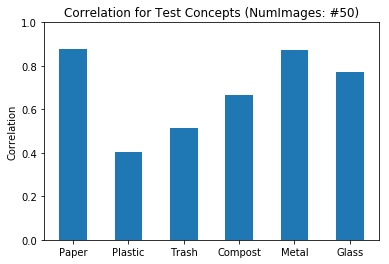

In [61]:
plt.close('all')
barWidth = 0.5
plt.bar(range(1,7),win0_50, width = barWidth)
plt.xticks(range(1,7),allConcepts)
plt.title("Correlation for Test Concepts (NumImages: #50)")
plt.ylabel('Correlation')
plt.ylim(0,1)
plt.show()

In [20]:
correlation_50

[0.8791125311273522,
 0.40479140380407114,
 0.5151289246513693,
 0.6639181954905902,
 0.8719009745606465,
 0.7730519771971549]

In [21]:
allConcepts

['Paper', 'Plastic', 'Trash', 'Compost', 'Metal', 'Glass']

## Save the output ratings as EstimatesNewConcepts.csv

In [24]:
conceptNames = []
colorRow = []
for i in range(len(allConcepts)):
    for j in range(numColors):
        conceptNames.append(allConcepts[i])
        colorRow.append(j+1)


matrix = np.column_stack((np.array(conceptNames), np.array(colorRow), np.array(win1_50).flatten(), np.array(win2_50).flatten()))
print(matrix.shape)

df = pd.DataFrame(matrix)
## save to csv file
print(df.head())
filepath = 'EstimatesNewConcepts.csv'
df.to_csv(filepath, index=False, columns = ["Concept","Color","True Rating","Sector+Category Model Estimates"])


# Scatter Plots 

In [70]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 9})
def createScatterPlots(indices, win0, win1, win2,numImages):
    model_num = 3
    print("----------------------- Creating plots for Model ---------------Sector+Category")
    # print(indices)
    # print(win0)
    
    k = 1
    plt.close('all')
    plt.subplots(2,3,figsize=(5,4))
    for i in range(len(indices)-1,-1,-1):
        # Scatter plot

        arg = indices[i]
        trueRating = win1[arg]
        avg_pred = win2[arg]

        ax = plt.subplot(2,3,k,aspect='equal') #plt.figure(figsize=(7,7))
        #ax = f.add_subplot(3,4,k)
        plt.scatter(trueRating,avg_pred,c=colorDataRGB.values,marker = 'o',s=15) #, edgecolor = [0,0,0])
        if k == 1 or k == 4:
            plt.ylabel('Mean Predicted Rating')
        plt.xlabel('Mean Rating')
        s = allConcepts[arg]+"( %.2f )" %win0[arg]
        #print(s)
        plt.title(s)
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.yticks([0,0.5,1])
        plt.xticks([0,0.5,1])
        plt.tick_params(direction='in')
        plt.plot(np.unique(trueRating), np.poly1d(np.polyfit(trueRating, avg_pred, 1))(np.unique(trueRating)),'k--')
        k = k+1
    plotName = "Test_ScatterPlot_Model_"+str(numImages)+".pdf"
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    #plt.savefig(plotName, bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    
    


----------------------- Creating plots for Model ---------------Sector+Category


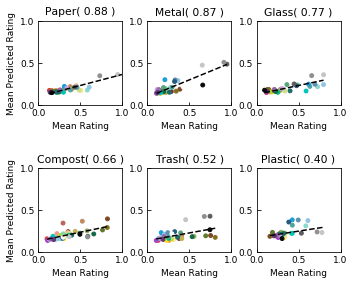

In [71]:
indices = np.argsort(win0_50)
createScatterPlots(indices, win0_50, win1_50, win2_50,50)

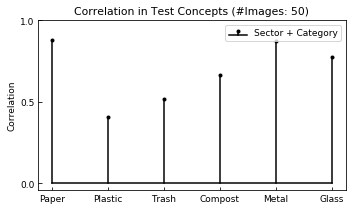

In [72]:
plt.close('all')
barWidth = 0.1
#r1 = [0.4,0.8,1.2,1.6,2,2.4]
r1 = [0.1,0.4,0.7,1,1.3,1.6]
r2 = [x + barWidth for x in r1]
r3 = [x + 2*barWidth for x in r1]

#t.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='poacee')
fig = plt.figure(figsize =(5,3)) # (3,1.5)

mline3 = plt.stem(r1,correlation_50,label='Sector + Category')
plt.setp(mline3, color=[0,0,0], linewidth=1.5, markersize = 3)

plt.xticks(r1,allConcepts)
plt.yticks([0,0.5,1])
plt.tick_params(direction='in')
plt.title("Correlation in Test Concepts (#Images: 50)")
plt.ylabel('Correlation')
plt.legend()

plt.tight_layout()
plt.savefig('Exp3_Correlation.pdf')
plt.show()


In [73]:
error_50

[1.9019227230146638,
 1.407303811767055,
 1.9371400882005407,
 1.8387030863792606,
 0.8006076720127271,
 2.0554486581870988]

In [74]:
correlation_50

[0.8791125311273522,
 0.40479140380407114,
 0.5151289246513693,
 0.6639181954905902,
 0.8719009745606465,
 0.7730519771971549]

In [75]:
cor_50,_ = stats.pearsonr(np.array(win2_50).flatten(), np.array(win1_50).flatten())

In [76]:
print("Overall correlation for top 50 is:",cor_50)

Overall correlation for top 50 is: 0.6783553152733253
